In [13]:
!pip install torch torchvision torchtext pandas spacy scikit-learn torchsummary seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [14]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
# tell pytorch to use the gpu if available
if torch.cuda.is_available():    
      
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3080


In [16]:
# 定义基本参数
num_classes = 4  # AG News有四个类别
batch_size = 64
num_epochs = 3
k_folds = 3
input_size = 5000  # TF-IDF特征的维度

In [17]:
# 读取数据集
train_df = pd.read_csv('train.csv')  # 请将此路径替换为实际文件路径
test_df = pd.read_csv('test.csv')    # 请将此路径替换为实际文件路径

In [18]:
train_df

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [19]:
test_df

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [20]:
# 合并训练和测试集的文本以构建TF-IDF向量器
all_texts = pd.concat([train_df['Description'], test_df['Description']])

# 使用TF-IDF向量器将文本转换为特征向量
tfidf_vectorizer = TfidfVectorizer(max_features=input_size)
tfidf_vectorizer.fit(all_texts)

# 将训练和测试集的文本转换为TF-IDF特征矩阵
X_train = tfidf_vectorizer.transform(train_df['Description']).toarray()
y_train = train_df['Class Index'].values - 1  # 标签从0开始

X_test = tfidf_vectorizer.transform(test_df['Description']).toarray()
y_test = test_df['Class Index'].values - 1  # 标签从0开始

# 定义自定义数据集
class AGNewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 创建训练和测试数据集
train_dataset = AGNewsDataset(X_train, y_train)
test_dataset = AGNewsDataset(X_test, y_test)

In [21]:
# 定义简单的前馈神经网络模型
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        logits = self.fc2(out)
        return logits

In [ ]:
# 设置K折交叉验证
kfold = KFold(n_splits=k_folds, shuffle=True)

best_val_accuracy = 0.0
best_model_state = None

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    print('----------------------------')

    # 创建数据采样器和加载器
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)

    # 初始化模型、损失函数和优化器
    model = SimpleNN(input_size, hidden_size=256, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        total_acc, total_count = 0, 0

        for features, labels in train_loader:
            optimizer.zero_grad()
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

        print(f'Epoch {epoch + 1}, Training accuracy: {total_acc / total_count:.4f}')

    # 验证模型
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    val_accuracy = total_acc / total_count
    print(f'Validation accuracy: {val_accuracy:.4f}\n')

    # 保存验证准确率最高的模型
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

Fold 1/3
----------------------------
Epoch 1, Training accuracy: 0.8743
Epoch 2, Training accuracy: 0.9128


In [11]:
# 使用整个训练集训练最终模型
final_model = TextRNN(len(vocab), embedding_dim, hidden_dim, num_classes).to(device)
final_model.load_state_dict(best_model_state)  # 使用最佳模型的参数初始化
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)

# 创建完整的训练数据加载器
full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# 再训练模型，使用整个训练集
for epoch in range(num_epochs):
    final_model.train()
    total_acc, total_count = 0, 0

    for texts, labels, lengths in full_train_loader:
        optimizer.zero_grad()
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
        outputs = final_model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

    print(f'Final Epoch {epoch + 1}, Training accuracy: {total_acc / total_count:.4f}')

Final Epoch 1, Training accuracy: 0.9584
Final Epoch 2, Training accuracy: 0.9713
Final Epoch 3, Training accuracy: 0.9788
Final Epoch 4, Training accuracy: 0.9841
Final Epoch 5, Training accuracy: 0.9879


Classification Report:
              precision    recall  f1-score   support

           0     0.9260    0.8953    0.9104      1900
           1     0.9419    0.9732    0.9573      1900
           2     0.8940    0.8342    0.8631      1900
           3     0.8407    0.8968    0.8678      1900

    accuracy                         0.8999      7600
   macro avg     0.9006    0.8999    0.8996      7600
weighted avg     0.9006    0.8999    0.8996      7600

Confusion Matrix:
[[1701   61   65   73]
 [  22 1849   15   14]
 [  56   23 1585  236]
 [  58   30  108 1704]]


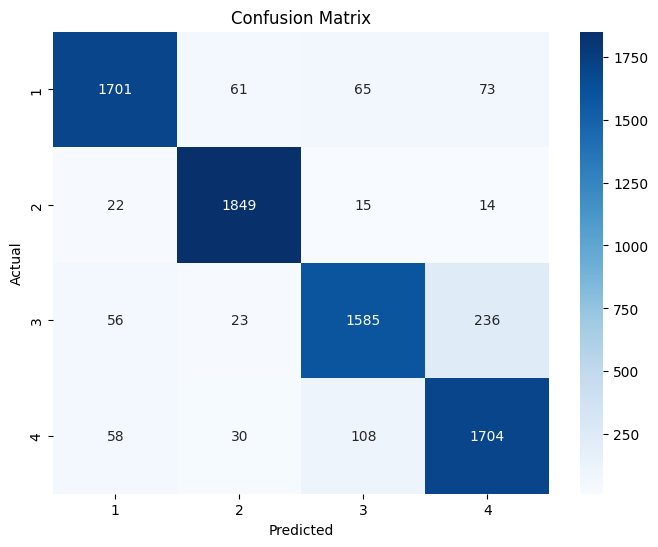

In [12]:
# 在测试集上评估模型
final_model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)
    for texts, labels, lengths in test_loader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
        outputs = final_model(texts, lengths)
        preds = outputs.argmax(1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 生成分类报告
print("Classification Report:")
print(classification_report(test_labels, test_preds, digits=4))

# 生成混淆矩阵
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()